# Purpose

This script is used to apply the 8 timseries cross-validation models to the the test data (for 2022). As a test of sensitivity, we will fill all of the pump data with zero values and see how the models perform. They should be pretty terrible (performance wise) and we should see higher predicted temperatures than the actual temperatures.

In [17]:
#high level modules
import os
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/temperature/denseNN/"

imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test, predict_2_values_test, return_test_error_metrics

imp.load_source("vis", os.path.join(this_dir, "vis_functions.py"))
from vis import ts_plot, create_scatter_plot_test

We need to read in the transformed test data, apply the models, and save the predictions.

In [19]:
# import test data
file_path = os.path.expanduser("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_autoNN_daily/")

test_fn = os.path.join(file_path, "t2022_standardized_v2024-05-21.csv")
with open(test_fn) as f:
    test = pd.read_csv(f, sep=',')

And now, we'll zero out all of the pump data. In order to do that, we need to know what the standardized pump value of 0 is. We can get that from the standardization file.

In [20]:
transform = pd.read_csv(os.path.join("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_autoNN_daily/", "mean_std_train_val_t2022_v2024-05-21.csv"), sep=',')
transform = transform.rename(columns={"Unnamed: 0": "feature"}).set_index("feature")

pump_cols = ['pump_q_m1', 'pump_q_m2', 'mean_pump_q_p2', 'sum_pump_q_p2', 'max_pump_q_p2', 'mean_pump_q_p7', 
            'sum_pump_q_p7', 'max_pump_q_p7']

for col in pump_cols:
    test[col] = (0 - transform.loc[col, 'mean']) / transform.loc[col, 'std']

And we need to filter this for our target date - Jul 1 through Sept 11.

In [21]:
# arrange the data by date
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(by='date')
test = test.loc[test['date'].between('2022-07-01', '2022-09-11')]

Now we need to apply the models to the test data, but first we need to format the data for the models

In [22]:
test_features, test_labels = twotemp_labels_features_test(test)

Load the models

In [23]:
# load the models
model_dir = '/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_autoNN_daily/models/leaky_basic_3/'

models = [f for f in os.listdir(model_dir) if 'history' not in f]

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)


Now we need to apply the models to the test data and get the predictions, for which we also need the standarization parameters to back calculate.

In [24]:
t_mean_1m = transform['mean'].get('mean_1m_temp_degC')
t_std_1m = transform['std'].get('mean_1m_temp_degC')

t_mean_05m = transform['mean'].get('mean_0_5m_temp_degC')
t_std_05m = transform['std'].get('mean_0_5m_temp_degC')

test["pred_1m_1"], test["pred_05m_1"] = predict_2_values_test(model_1, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_2"], test["pred_05m_2"] = predict_2_values_test(model_2, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_3"], test["pred_05m_3"] = predict_2_values_test(model_3, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_4"], test["pred_05m_4"] = predict_2_values_test(model_4, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_5"], test["pred_05m_5"] = predict_2_values_test(model_5, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_6"], test["pred_05m_6"] = predict_2_values_test(model_6, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_7"], test["pred_05m_7"] = predict_2_values_test(model_7, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_8"], test["pred_05m_8"] = predict_2_values_test(model_8, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)

And now, let's make the ensemble prediction to assess the model performance.

In [25]:
test["ts_cv_ensemble_pred_1m"] = np.mean(test[['pred_1m_1', 'pred_1m_2', 'pred_1m_3', 'pred_1m_4', 'pred_1m_5', 'pred_1m_6', 'pred_1m_7', 'pred_1m_8']], axis=1)
test["ts_cv_ensemble_pred_05m"] = np.mean(test[['pred_05m_1', 'pred_05m_2', 'pred_05m_3', 'pred_05m_4', 'pred_05m_5', 'pred_05m_6', 'pred_05m_7', 'pred_05m_8']], axis=1)

In order to compare these with the actual values, we need to load the actual values and calculate the performance metrics. To do this, we will back-calculate using the mean and standard deviation.

In [26]:
test['mean_1m_temp_degC'] = test['mean_1m_temp_degC'] * t_std_1m + t_mean_1m
test['mean_0_5m_temp_degC'] = test['mean_0_5m_temp_degC'] * t_std_05m + t_mean_05m

Let's look at the data from 1m first:

In [27]:
return_test_error_metrics(test["mean_1m_temp_degC"], test["ts_cv_ensemble_pred_1m"])

Test Datset Error Metrics:
Mean Squared Error: 0.474646664562962
Mean Absolute Error: 0.5725961529668837
Root Mean Squared Error: 0.688946053449007
Mean Absolute Percentage Error: 0.03449053931084845


(0.474646664562962, 0.5725961529668837, 0.688946053449007, 0.03449053931084845)

And then the data from 0-5m:

In [28]:
return_test_error_metrics(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 1.6419171499373726
Mean Absolute Error: 1.167489712339483
Root Mean Squared Error: 1.2813731501546974
Mean Absolute Percentage Error: 0.08528357889060628


(1.6419171499373726,
 1.167489712339483,
 1.2813731501546974,
 0.08528357889060628)

Let's look at this in context of the data:

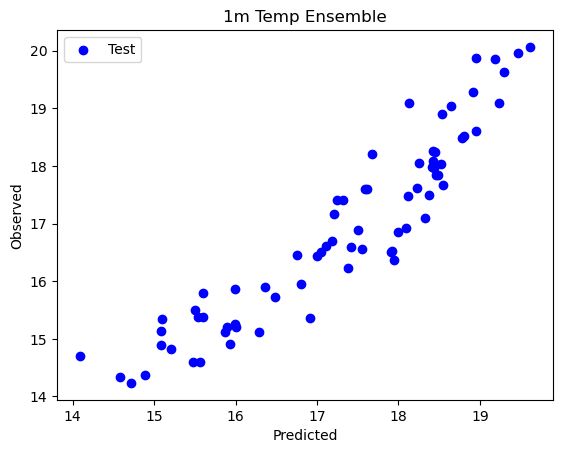

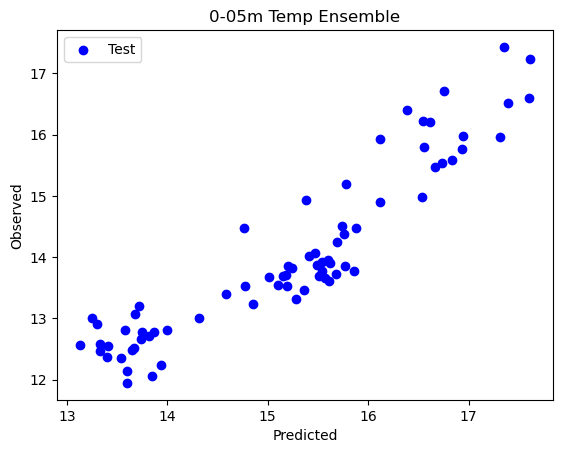

In [29]:
create_scatter_plot_test("1m Temp Ensemble", test["ts_cv_ensemble_pred_1m"], test["mean_1m_temp_degC"])
create_scatter_plot_test("0-05m Temp Ensemble", test["ts_cv_ensemble_pred_05m"], test["mean_0_5m_temp_degC"])

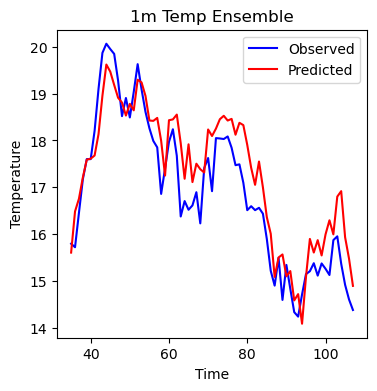

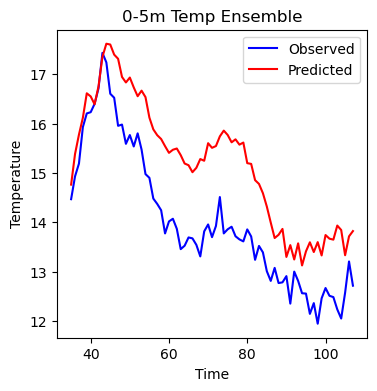

In [30]:
ts_plot(test["mean_1m_temp_degC"], test["ts_cv_ensemble_pred_1m"], "1m Temp Ensemble")
ts_plot(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"], "0-5m Temp Ensemble")


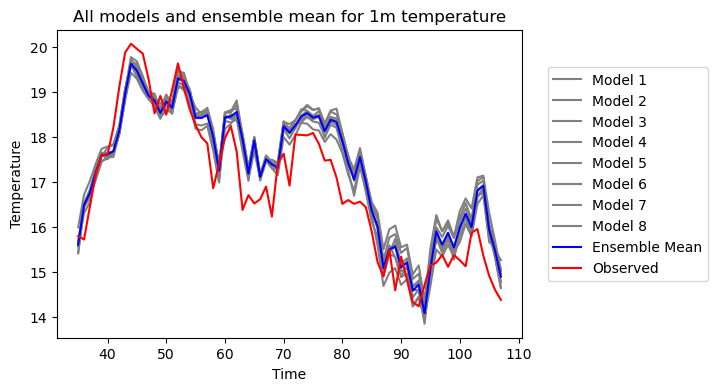

In [31]:
plt.figure(figsize=(6,4))
plt.plot(test["pred_1m_1"], label="Model 1", color='grey')
plt.plot(test["pred_1m_2"], label="Model 2", color='grey')
plt.plot(test["pred_1m_3"], label="Model 3", color='grey')
plt.plot(test["pred_1m_4"], label="Model 4", color='grey')
plt.plot(test["pred_1m_5"], label="Model 5", color='grey')
plt.plot(test["pred_1m_6"], label="Model 6", color='grey')
plt.plot(test["pred_1m_7"], label="Model 7", color='grey')
plt.plot(test["pred_1m_8"], label="Model 8", color='grey')
plt.plot(test["ts_cv_ensemble_pred_1m"], label="Ensemble Mean", color='blue')
plt.plot(test["mean_1m_temp_degC"], label="Observed", color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(bbox_to_anchor=(1.04, 0.9))
plt.title("All models and ensemble mean for 1m temperature")
plt.show()

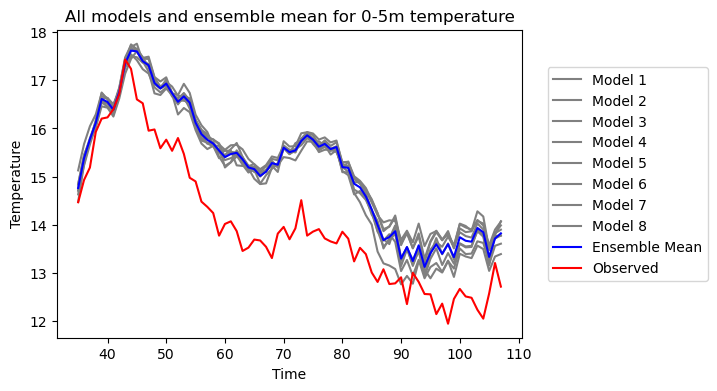

In [32]:
plt.figure(figsize=(6,4))
plt.plot(test["pred_05m_1"], label="Model 1", color='grey')
plt.plot(test["pred_05m_2"], label="Model 2", color='grey')
plt.plot(test["pred_05m_3"], label="Model 3", color='grey')
plt.plot(test["pred_05m_4"], label="Model 4", color='grey')
plt.plot(test["pred_05m_5"], label="Model 5", color='grey')
plt.plot(test["pred_05m_6"], label="Model 6", color='grey')
plt.plot(test["pred_05m_7"], label="Model 7", color='grey')
plt.plot(test["pred_05m_8"], label="Model 8", color='grey')
plt.plot(test["ts_cv_ensemble_pred_05m"], label="Ensemble Mean", color='blue')
plt.plot(test["mean_0_5m_temp_degC"], label="Observed", color='red')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend(bbox_to_anchor=(1.04, 0.9))
plt.title("All models and ensemble mean for 0-5m temperature")
plt.show()